In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

import orc.models
import orc.rc

# Generate lorenz data

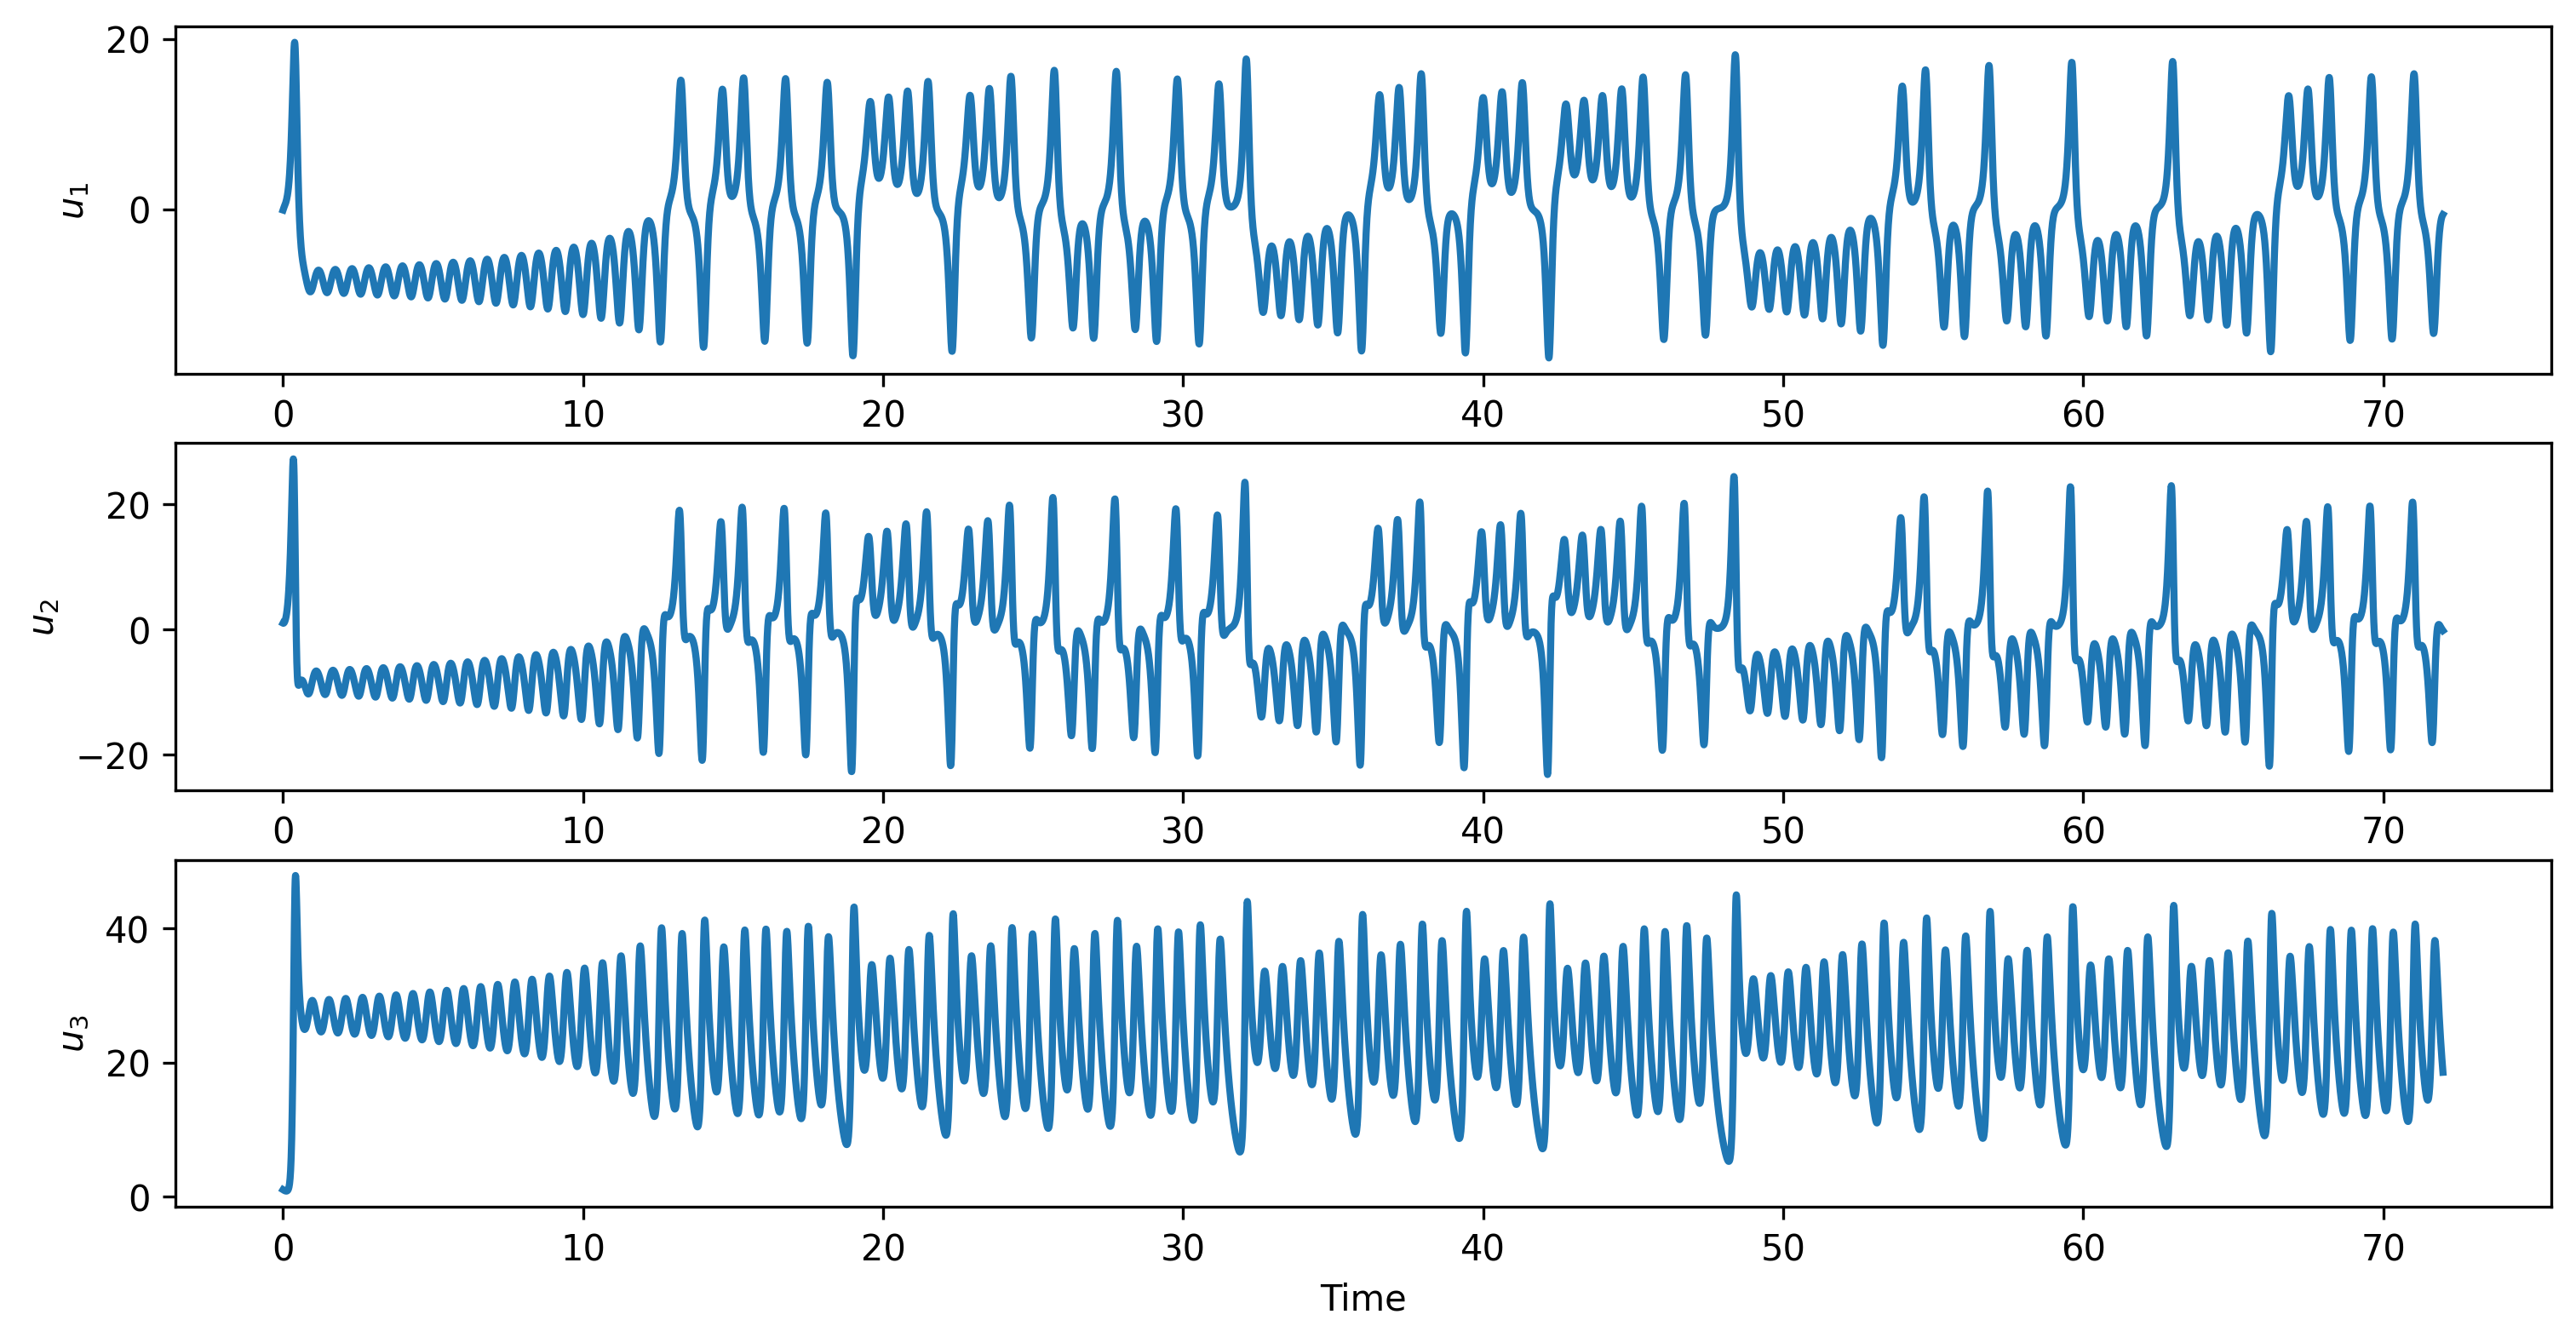

In [2]:
### Integrate + Plot Lorenz63 System

#xdot = f(x) definition
def lorenz(t,x):
    beta, rho, sigma = 8/3, 28, 10
    x1, x2, x3 = x
    dx1dt = sigma*(x2 - x1)
    dx2dt = x1*(rho - x3) - x2
    dx3dt = x1*x2 - beta*x3
    return np.array([dx1dt, dx2dt, dx3dt])

# integrate 
tN = 100
dt = 0.01
sol = scipy.integrate.solve_ivp(lorenz, t_span=(0,tN), y0=[-0.1, 1, 1.05], dense_output=True, rtol = 1e-12, atol = 1e-12, method = 'RK45')
t = np.arange(0,tN,dt)
U = sol.sol(t) # of shape (3, tN/dt)

# train-test split
test_perc = 0.2
lyap = 0.9
split_idx = int((1-test_perc) * U.shape[1])
U_train = U[:, :split_idx].T
t_train = t[:split_idx].T * lyap
U_test = U[:, split_idx:].T 
t_test = t[split_idx:].T * lyap
# t_test = np.linspace(0, dt * U_test.shape[1], U_test.shape[1]) * lyap

# plot training data
fig, ax = plt.subplots(3,1, figsize=(12, 6), dpi = 300)
for i in range(3):
    ax[i].plot(t_train, U_train.T[i], linewidth = 2)
    ax[i].set_ylabel(r'$u_{}$'.format(i+1))
ax[i].set_xlabel('Time')
plt.show()

In [3]:
# init + train ESN
NR = 400
esn = orc.models.esn.ESN(data_dim=3, res_dim=NR, seed=0)
r0 = jnp.zeros((NR,))
esn, R = orc.rc.train_RC_forecaster(esn, U_train[:-1], U_train[1:])

# forecast 
U_pred = esn.forecast(fcast_len=U_test.shape[0], res_state=R[-1])

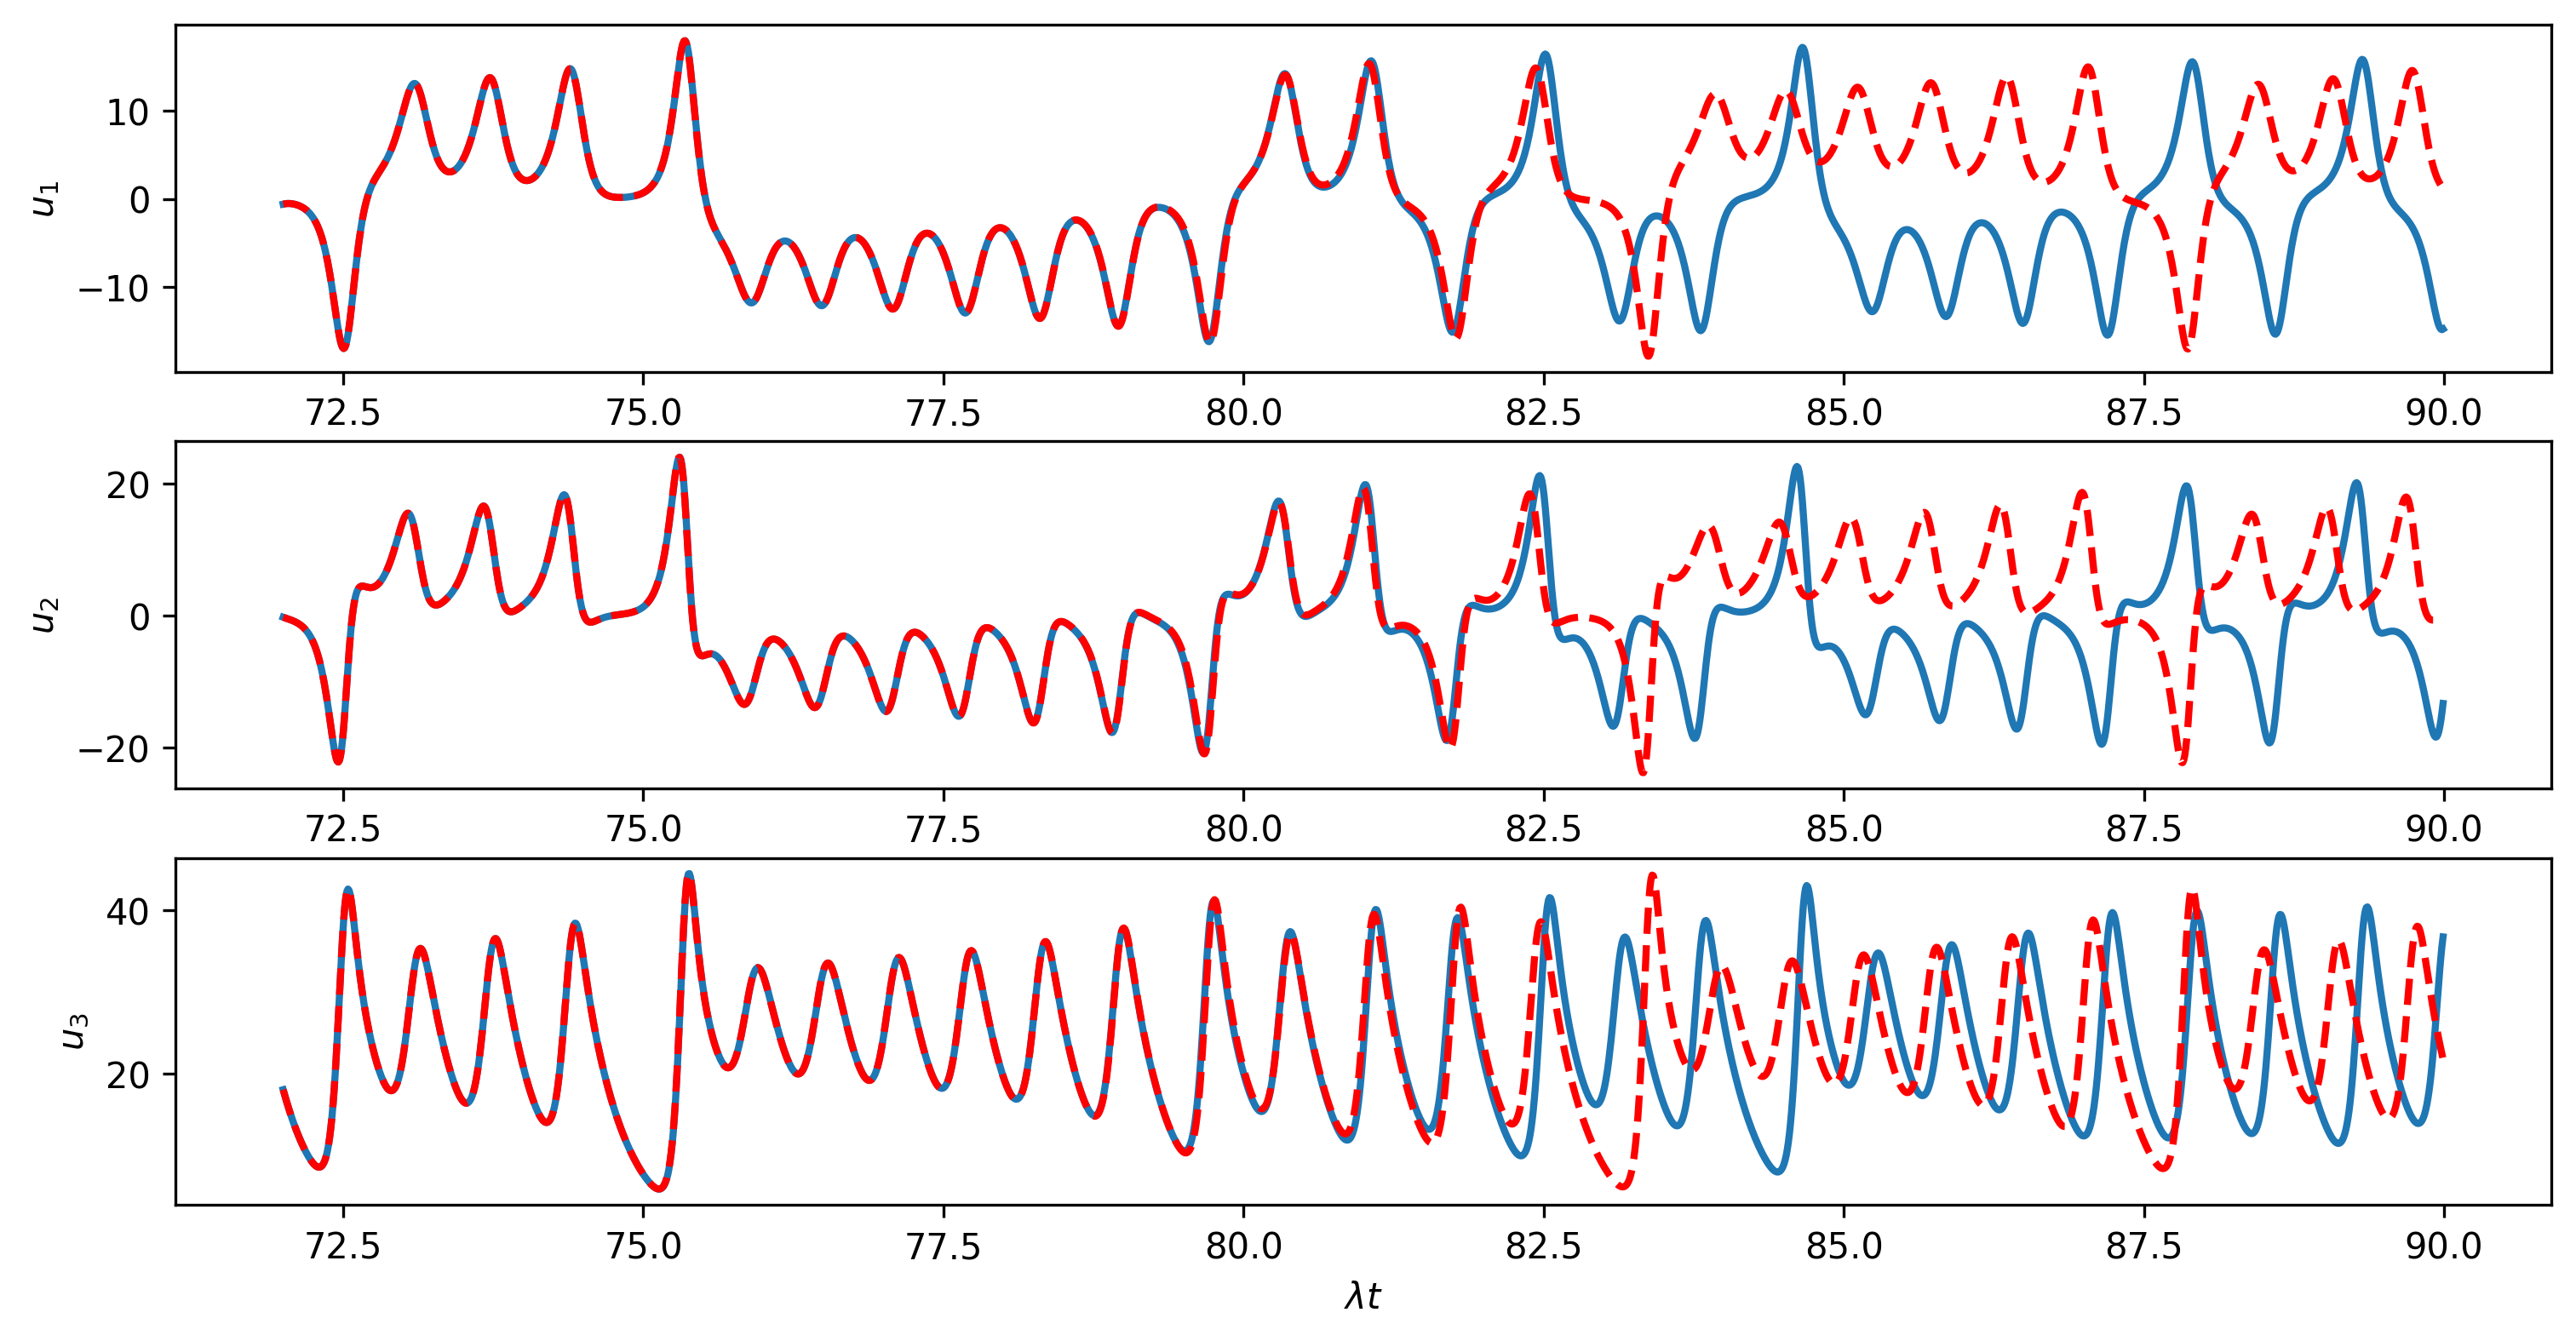

In [4]:
# plot forecast
lw = 2
fig, ax = plt.subplots(3,1, figsize=(12, 6), dpi = 300)
for i in range(3):
    ax[i].plot(t_test, U_test.T[i], label='True', linewidth = lw)
    ax[i].plot(t_test, U_pred.T[i], 'r--', label='Predicted', linewidth = lw)
    ax[i].set_ylabel(r'$u_{}$'.format(i+1))
ax[i].set_xlabel(r'$\lambda t$')
plt.show()
